In [2]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import awkward as ak
import os


In [3]:
# Directory path containing the ROOT files
directory_path = '/eos/purdue/store/user/lingqian/fullrun2_eft_minitrees/spinCorrInput_2016preVFP/Nominal'

# Define the specific files you want to include (with subdirectories)
desired_files = [
    'emu/emu_ttto2l2nu_jet_smeft_mtt_0to700_2016preVFP.root',
    'emu/emu_ttto2l2nu_jet_smeft_mtt_700to900_2016preVFP.root',
    'emu/emu_ttto2l2nu_jet_smeft_mtt_900toInf_2016preVFP.root'
]

# Construct the full paths for the desired files
file_paths = [os.path.join(directory_path, filename) for filename in desired_files]

# Open each ROOT file and extract the 'ttBar_treeVariables_step8' TTree
trees = [uproot.open(file_path)['ttBar_treeVariables_step8'] for file_path in file_paths]

# Concatenate the TTrees from all files into a single TTree
file = uproot.concatenate(trees)

In [4]:
mg_weight=file['mgWeights']
mg_weight

<Array [[1.14, 1.1, ..., 0.799, 0.799], ...] type='1001618 * var * float32'>

In [91]:
#Obtain the structure constant
import Event_weight_prediction
SC1= Event_weight_prediction.obtain_structure_constant(16, mg_weight)

In [92]:
import Data_store
Data_store.save_structure_constants(SC1, save_file='/depot/cms/top/bhanda25/EFT_minitree/Stored_SC/Stored_emu_Reco')

Structure constants saved to /depot/cms/top/bhanda25/EFT_minitree/Stored_SC/Stored_emu_Reco


In [5]:
# Directory path containing the ROOT files
dir_data = '/eos/purdue/store/user/lingqian/minitrees2016preVFP/spinCorrInput_2016preVFP_November2024/Nominal/'

# Define the specific files you want to include (with subdirectories)
all_files = [
    'emu/emu_ttbarsignalplustau_fromDilepton_2016ULpreVFP_0.root',
    'emu/emu_ttbarsignalplustau_fromDilepton_2016ULpreVFP_1.root',
    'emu/emu_ttbarsignalplustau_fromDilepton_2016ULpreVFP_2.root',
    'emu/emu_ttbarsignalplustau_fromDilepton_2016ULpreVFP_3.root',
    'emu/emu_ttbarsignalplustau_fromDilepton_2016ULpreVFP_4.root',
    'emu/emu_ttbarsignalplustau_fromDilepton_2016ULpreVFP_5.root',
    'emu/emu_ttbarsignalplustau_fromDilepton_2016ULpreVFP_6.root',
    'emu/emu_ttbarsignalplustau_fromDilepton_2016ULpreVFP_7.root',
    'emu/emu_ttbarsignalplustau_fromDilepton_2016ULpreVFP_8.root',
    'emu/emu_ttbarsignalplustau_fromDilepton_2016ULpreVFP_9.root',
    'emu/emu_ttbarsignalplustau_fromDilepton_2016ULpreVFP_10.root',
    'emu/emu_ttbarsignalplustau_fromDilepton_2016ULpreVFP_11.root'
    
]

# Construct the full paths for the desired files
paths = [os.path.join(dir_data, filename) for filename in all_files]

# Open each ROOT file and extract the 'ttBar_treeVariables_step8' TTree
trees_data = [uproot.open(file_path)['ttBar_treeVariables_step8'] for file_path in paths]

# Concatenate the TTrees from all files into a single TTree
file_data = uproot.concatenate(trees_data)

In [6]:
file_data

<Array [{top_pt: 23.1, top_phi: ..., ...}, ...] type='891189 * {top_pt: flo...'>

In [7]:
def plot_corrected_observables(obs, obs_sm_file, xlabel, title, corrected_weights, num_bins=6):
    fig, (ax, ax_ratio) = plt.subplots(2, 1, figsize=(12, 8),
                                       gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

    # Bin edges
    min_val = float(min(np.min(obs), np.min(obs_sm_file)))
    max_val = float(max(np.max(obs), np.max(obs_sm_file)))
    bin_edges = np.linspace(min_val, max_val, num_bins + 1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    bin_widths = np.diff(bin_edges)

    # Histograms
    counts_reweighted, _ = np.histogram(obs, bins=bin_edges, weights=corrected_weights)
    counts_sm_file, _ = np.histogram(obs_sm_file, bins=bin_edges)
    
    counts_reweighted = np.asarray(counts_reweighted)
    counts_sm_file = np.asarray(counts_sm_file)
    # Normalize
    norm_reweighted = np.sum(counts_reweighted) if np.sum(counts_reweighted) != 0 else 1
    norm_sm_file = np.sum(counts_sm_file) if np.sum(counts_sm_file) != 0 else 1
    stat_reweighted = np.sqrt(counts_reweighted) / norm_reweighted / bin_widths
    stat_sm_file = np.sqrt(counts_sm_file) / norm_sm_file / bin_widths


    # Main plot
    ax.hist(obs, bins=bin_edges, weights=corrected_weights, histtype='step',
            label="Reweighted_SM ", color='blue', density=True)
    ax.hist(obs_sm_file, bins=bin_edges, histtype='step', linestyle='dashed',
            label="SM (Powhegv2)", color='red', density=True)

    # Ratio plot
    ratio = np.divide(counts_reweighted / norm_reweighted, counts_sm_file / norm_sm_file,
                      out=np.ones_like(counts_sm_file, dtype=float), where=counts_sm_file != 0)
    total_uncertainty = np.sqrt(stat_reweighted**2 + stat_sm_file**2)

    ax_ratio.step(bin_centers, ratio, where='mid', color='black', label='Ratio')
    ax_ratio.fill_between(bin_centers, ratio - total_uncertainty, ratio + total_uncertainty,
                          step='mid', facecolor='gray', alpha=0.5)

    ax.set_ylabel("Normalized Events")
    ax.set_title(title)
    ax.legend(loc='best')
    ax_ratio.set_ylim(0.95, 1.05)
    ax_ratio.set_xlabel(xlabel)
    ax_ratio.set_ylabel("Corrected / Original")
    ax_ratio.axhline(1, color='gray', linestyle='--', linewidth=1)

    plt.tight_layout()
    plt.show()


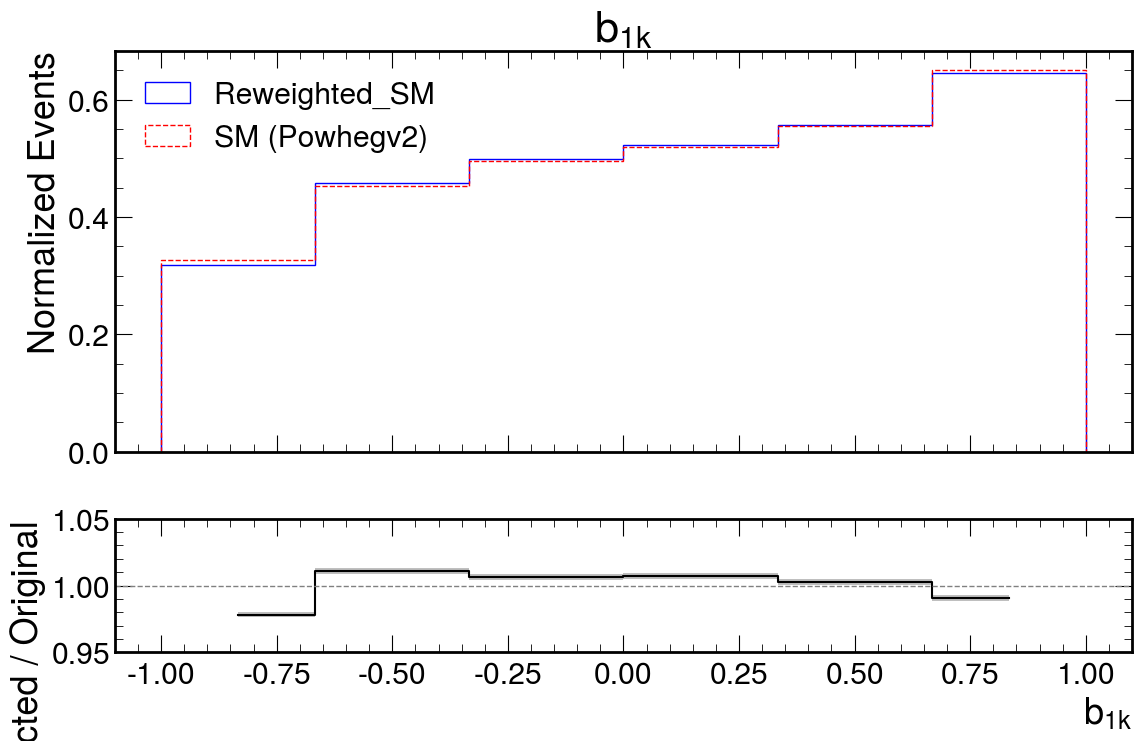

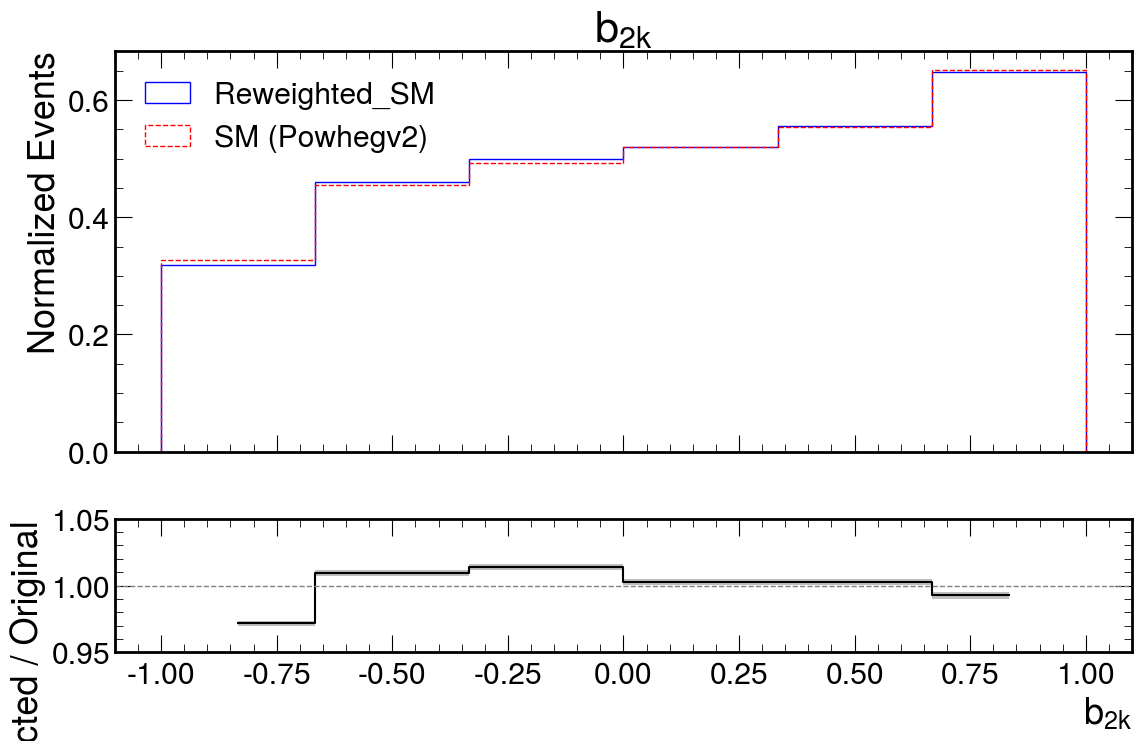

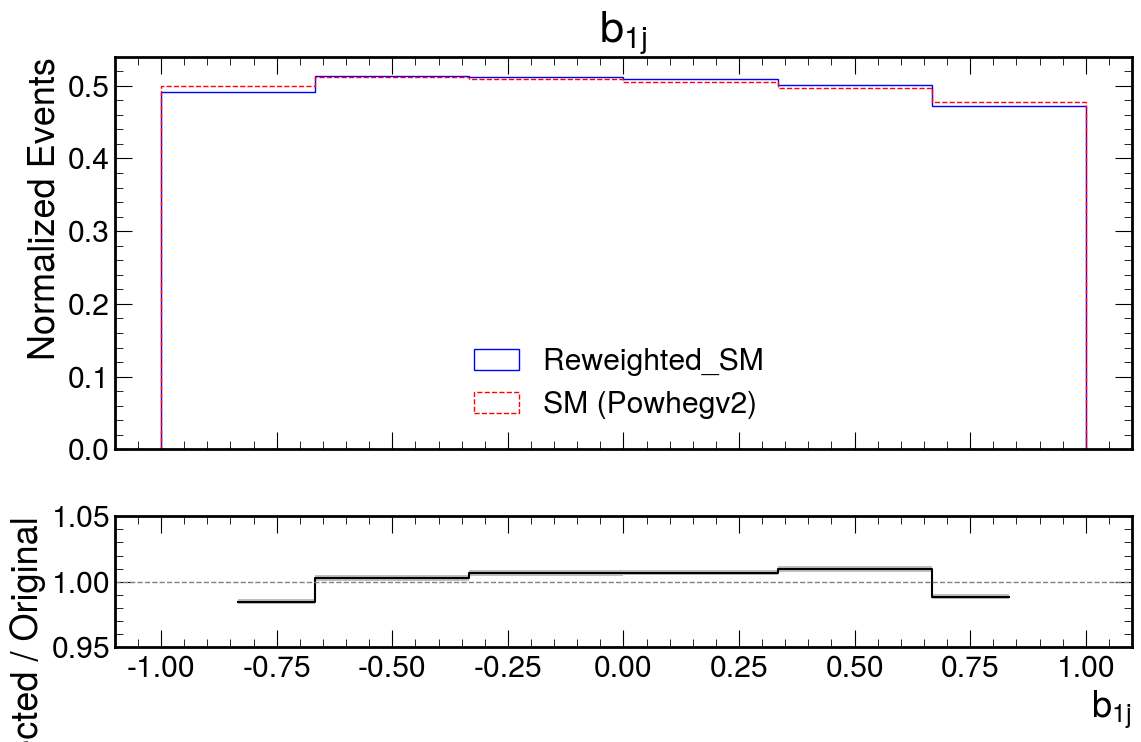

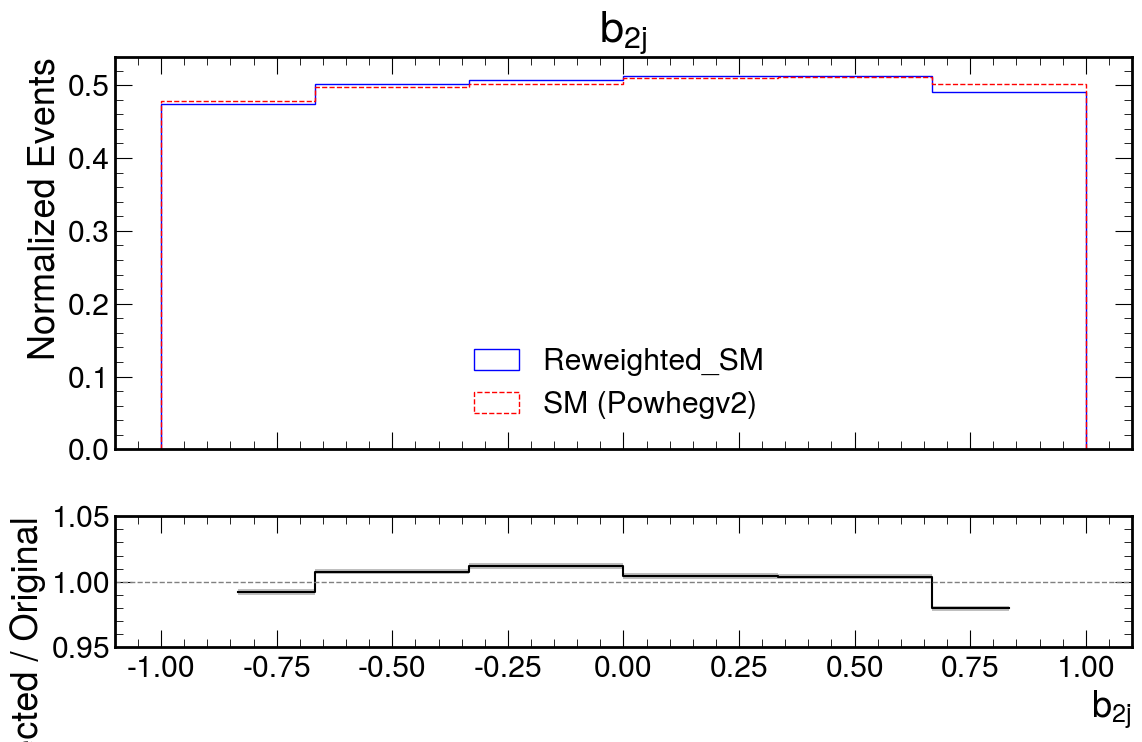

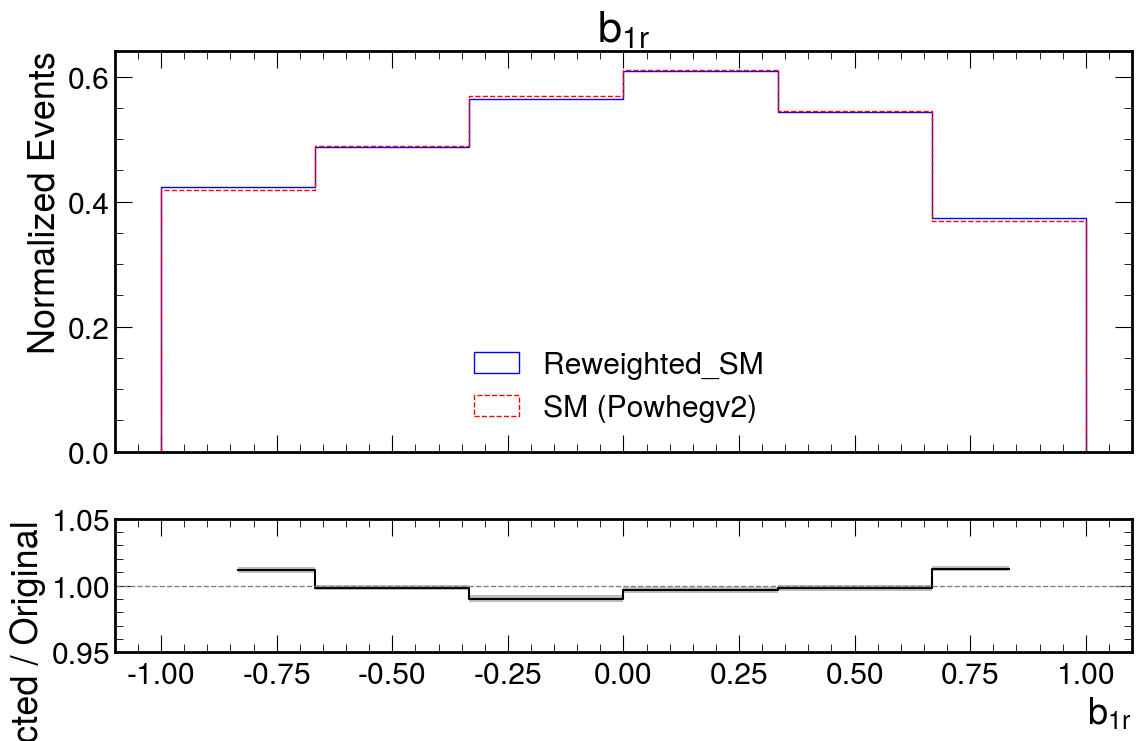

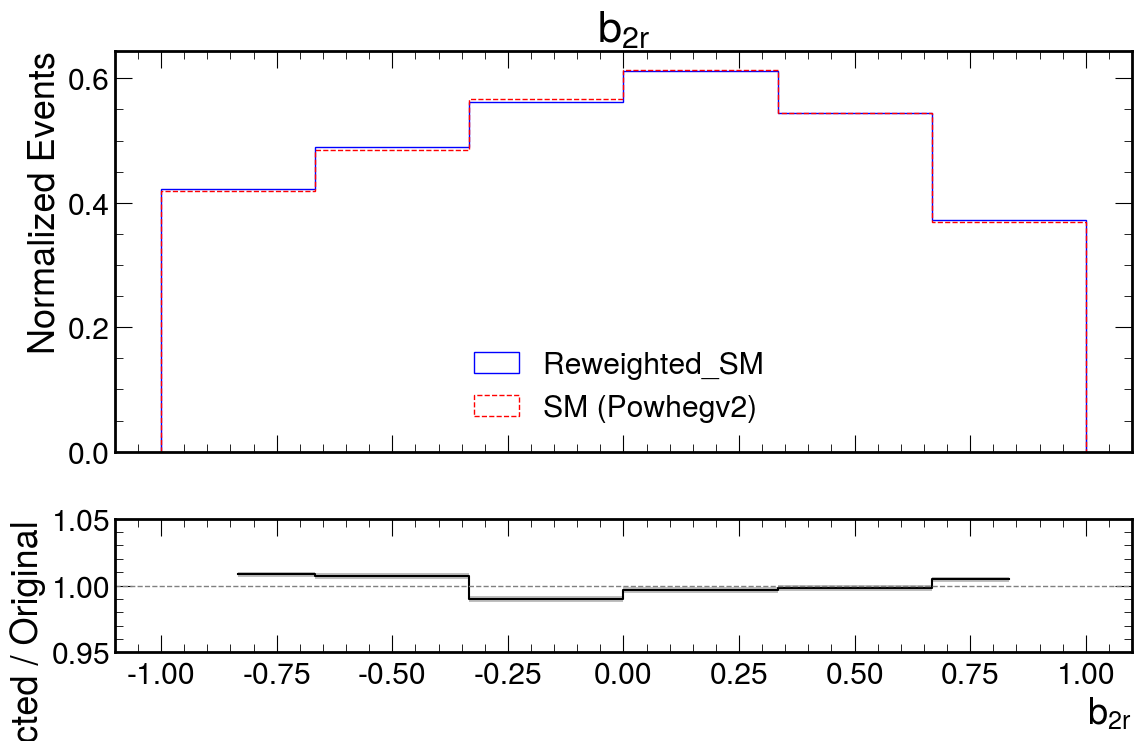

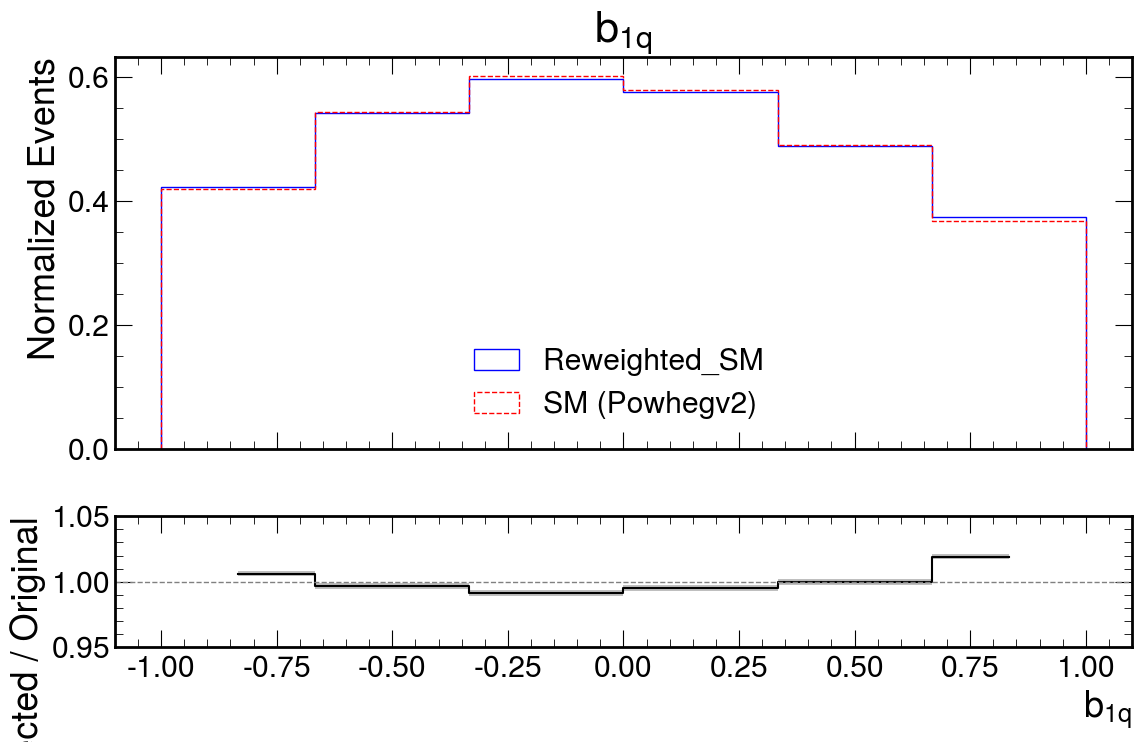

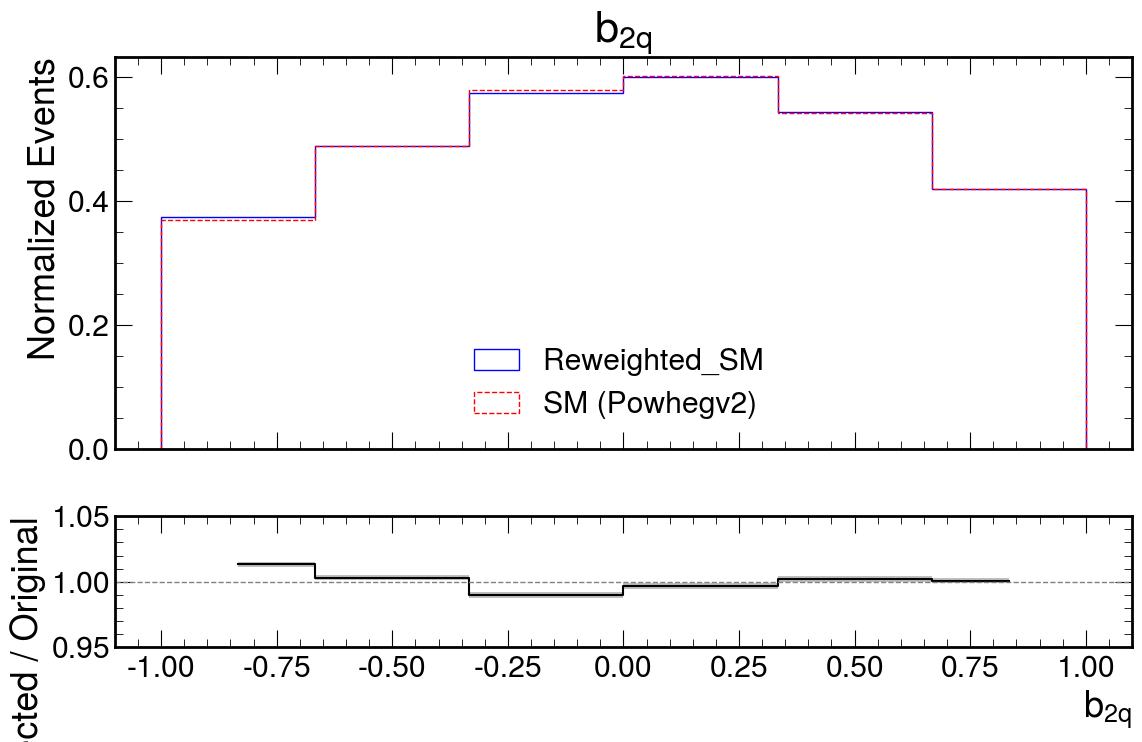

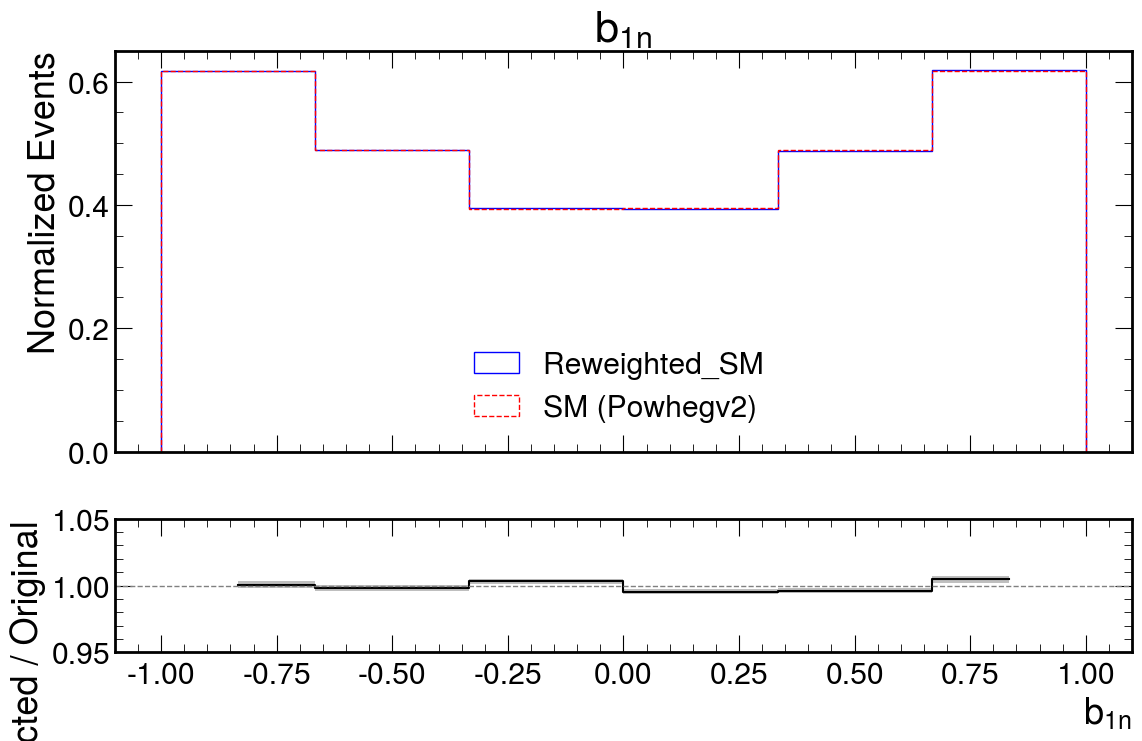

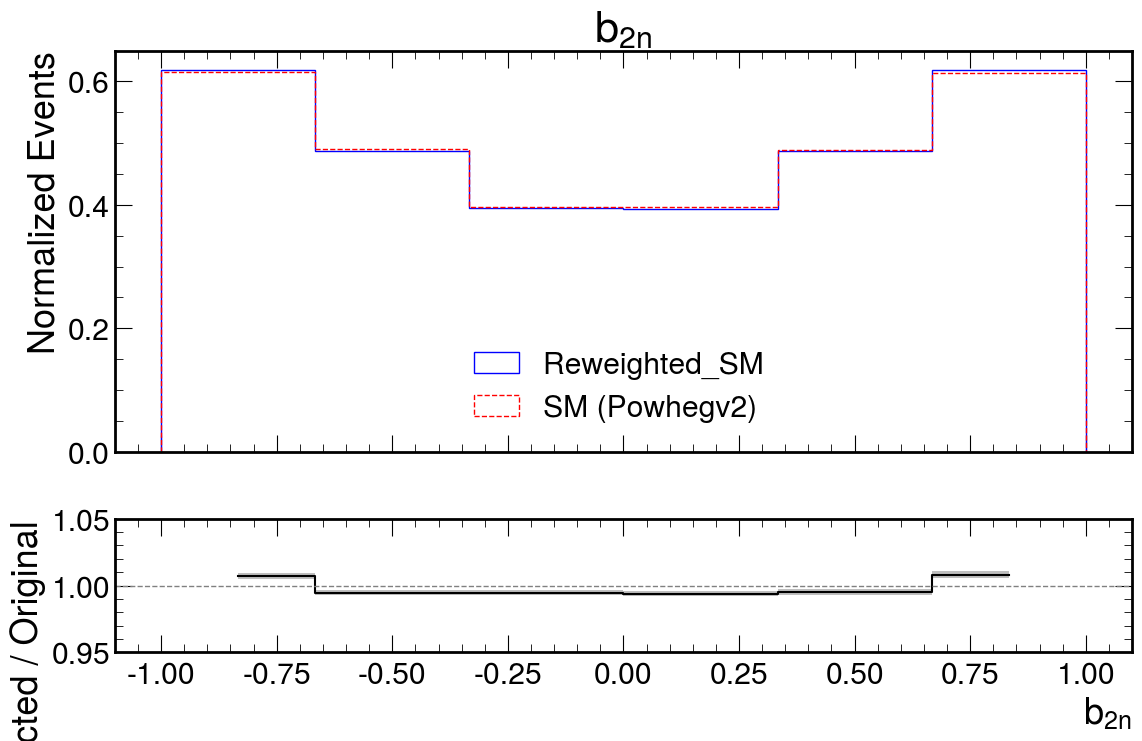

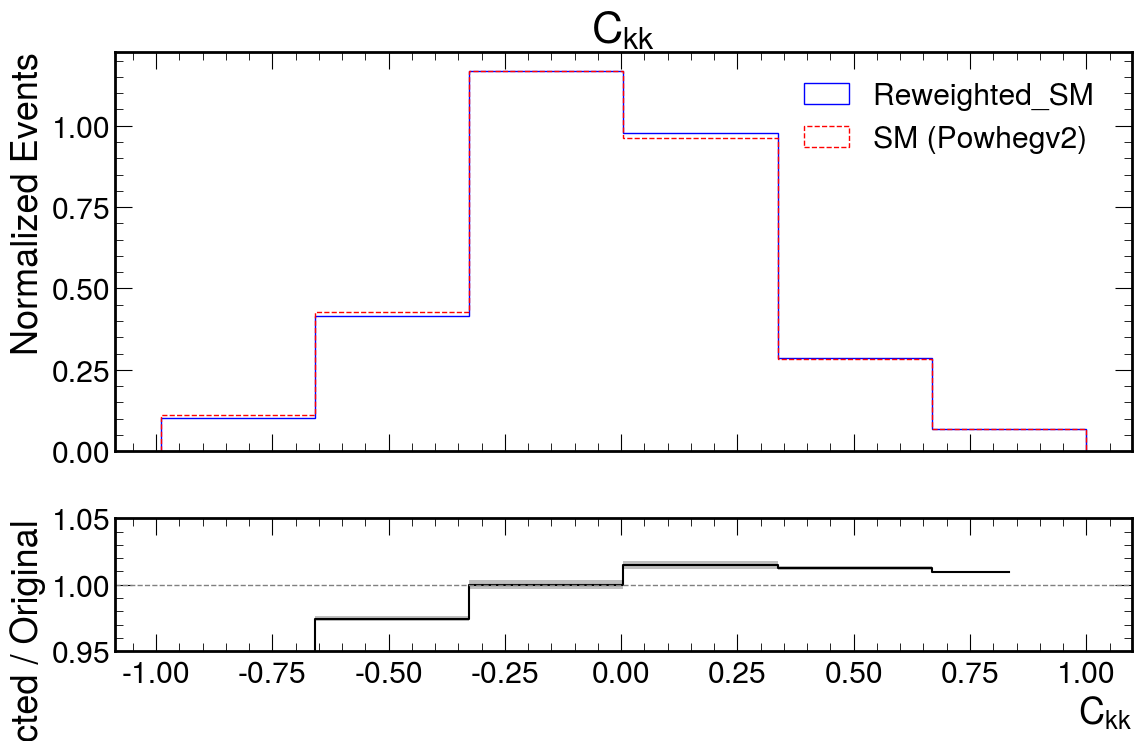

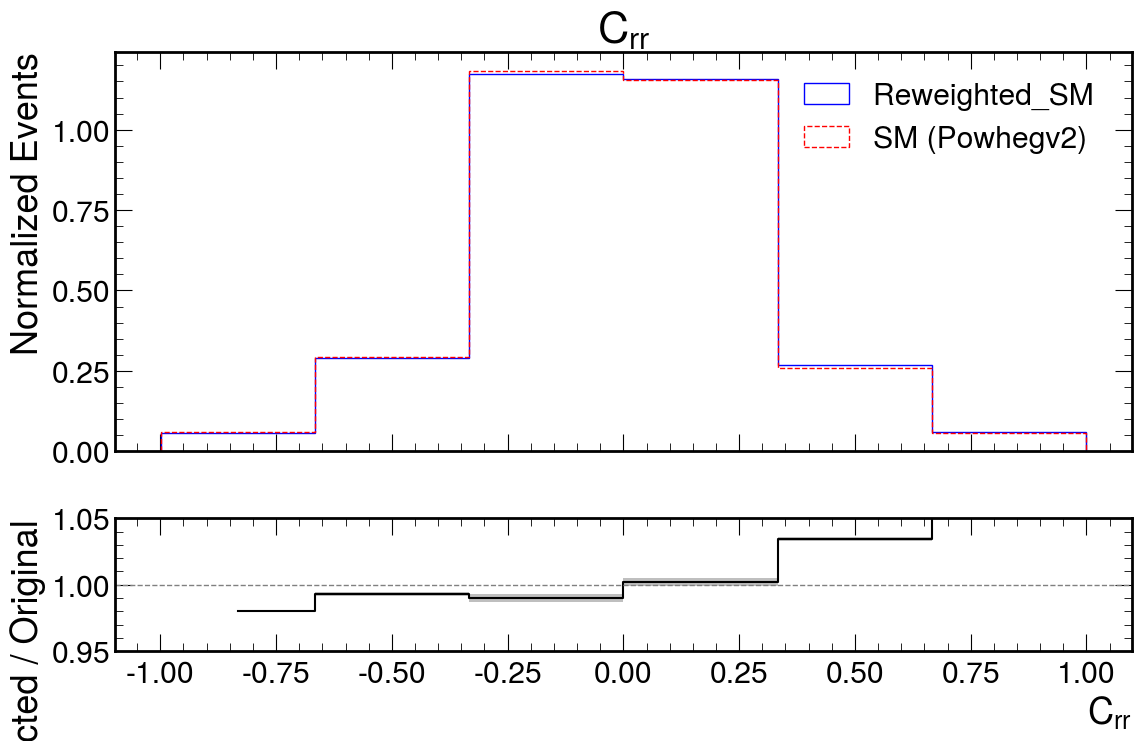

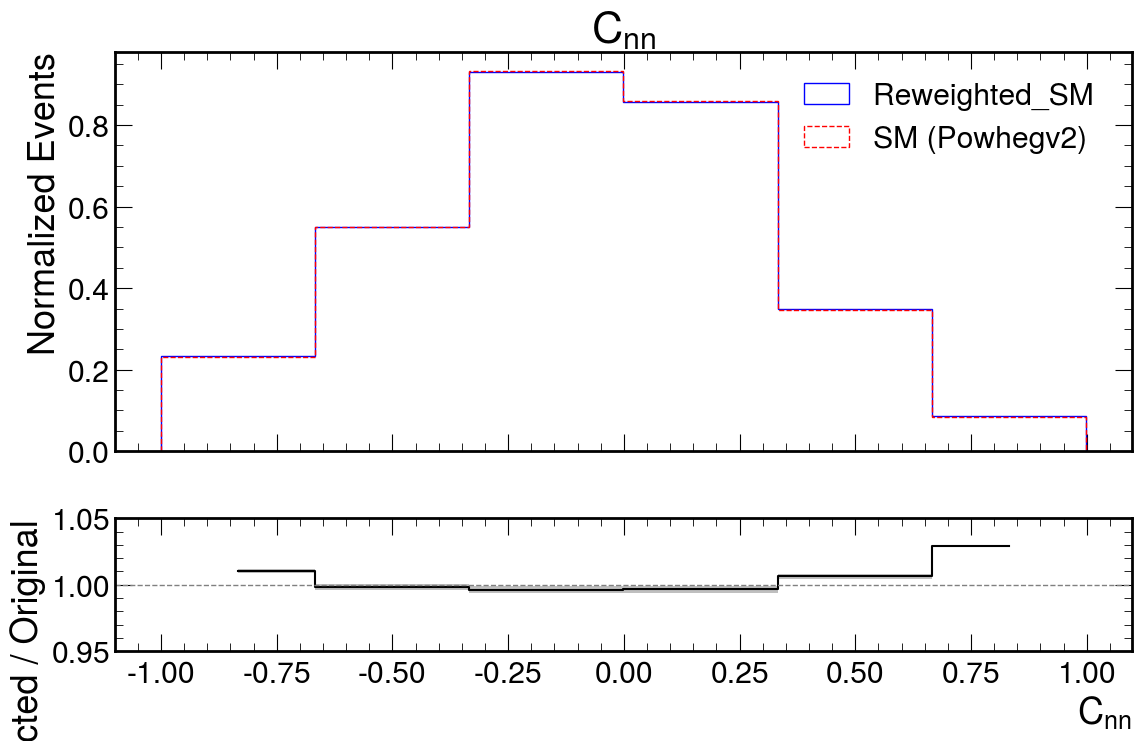

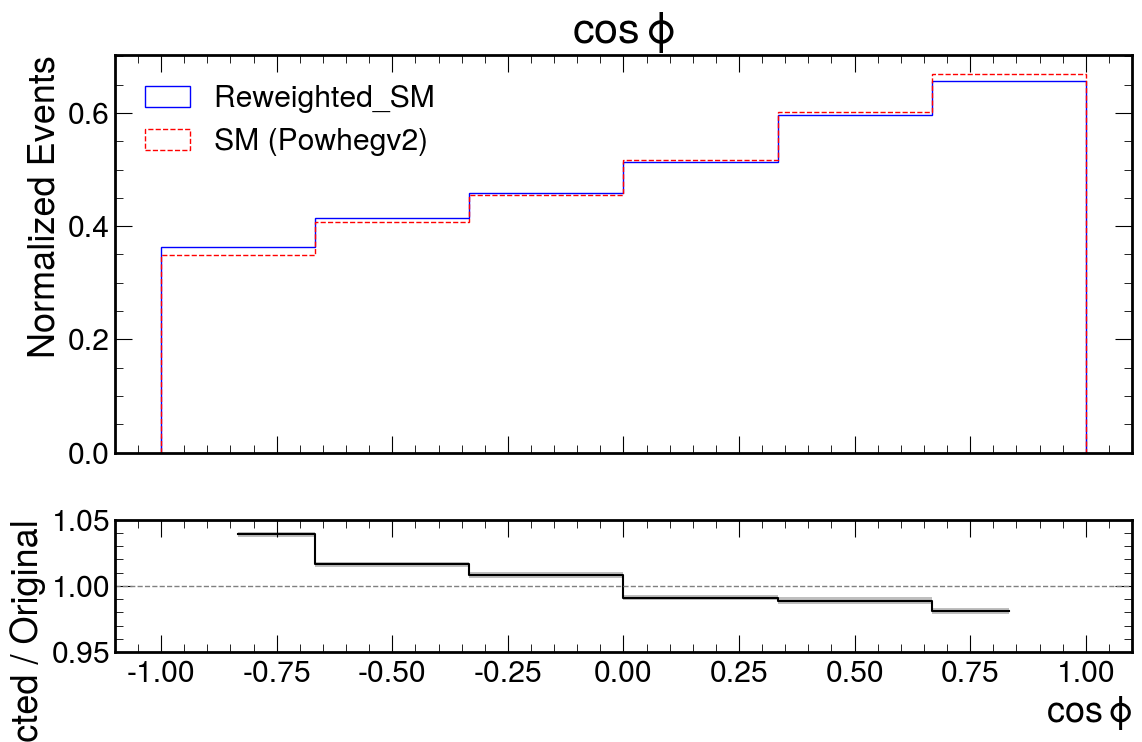

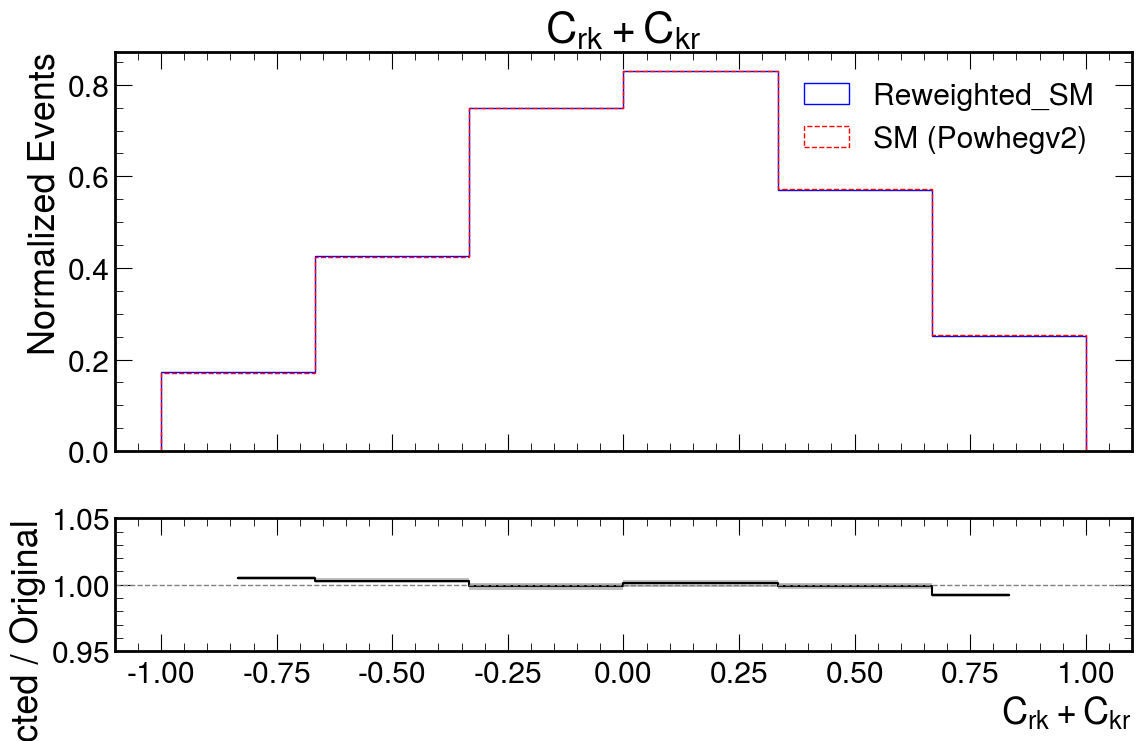

In [11]:
import plotting__script2
mask_file = (file['l_pt'] >= 1 ) & (file['lbar_pt'] >= 1)
observables = {
    'ttbar_mass': file['ttbar_mass'],
    'b1k': file['b1k'],
    'b2k': file['b2k'],
    'b1j': file['b1j'],
    'b2j': file['b2j'],
    'b1r': file['b1r'],
    'b2r': file['b2r'],
    'b1q': file['b1q'],
    'b2q': file['b2q'],
    'b1n': file['b1n'],
    'b2n': file['b2n'],
    'l_pt': file['l_pt'],
    'lbar_pt': file['lbar_pt'],
    'c_kk': file['c_kk'],
    'c_rr': file['c_rr'],
    'c_nn': file['c_nn'],
    'll_cHel': file['ll_cHel'],
    'crk_ckr': file['c_rk'] + file['c_kr'],
    'eta': file['l_eta'],

    'ttbar_pt': file['ttbar_pt'],
    'ttbar_phi': file['ttbar_phi'],
    'ttbar_rapidity': file['ttbar_rapidity'],
    'ttbar_eta': file['ttbar_eta'],
    'ttbar_delta_phi': file['ttbar_delta_phi'],
    'ttbar_delta_eta': file['ttbar_delta_eta'],
    'ttbar_delta_rapidity': file['ttbar_delta_rapidity'],
    'llbar_pt': file['llbar_pt'],
    'llbar_phi': file['llbar_phi'],
    'llbar_rapidity': file['llbar_rapidity'],
    'llbar_delta_phi': file['llbar_delta_phi'],
    'llbar_delta_eta': file['llbar_delta_eta'],
    'llbar_delta_rapidity': file['llbar_delta_rapidity'],
    'llbar_mass': file['llbar_mass'],
}

observables_data = {
    'ttbar_mass': file_data['ttbar_mass'],
    'b1k': file_data['b1k'],
    'b2k': file_data['b2k'],
    'b1j': file_data['b1j'],
    'b2j': file_data['b2j'],
    'b1r': file_data['b1r'],
    'b2r': file_data['b2r'],
    'b1q': file_data['b1q'],
    'b2q': file_data['b2q'],
    'b1n': file_data['b1n'],
    'b2n': file_data['b2n'],
    'l_pt': file_data['l_pt'],
    'lbar_pt': file_data['lbar_pt'],
    'c_kk': file_data['c_kk'],
    'c_rr': file_data['c_rr'],
    'c_nn': file_data['c_nn'],
    'll_cHel': file_data['ll_cHel'],
    'crk_ckr': file_data['c_rk'] + file_data['c_kr'],
    'eta': file_data['l_eta'],

    'ttbar_pt': file_data['ttbar_pt'],
    'ttbar_phi': file_data['ttbar_phi'],
    'ttbar_rapidity': file_data['ttbar_rapidity'],
    'ttbar_eta': file_data['ttbar_eta'],
    'ttbar_delta_phi': file_data['ttbar_delta_phi'],
    'ttbar_delta_eta': file_data['ttbar_delta_eta'],
    'ttbar_delta_rapidity': file_data['ttbar_delta_rapidity'],
    'llbar_pt': file_data['llbar_pt'],
    'llbar_phi': file_data['llbar_phi'],
    'llbar_rapidity': file_data['llbar_rapidity'],
    'llbar_delta_phi': file_data['llbar_delta_phi'],
    'llbar_delta_eta': file_data['llbar_delta_eta'],
    'llbar_delta_rapidity': file_data['llbar_delta_rapidity'],
    'llbar_mass': file_data['llbar_mass'],
}

# Include LaTeX-style labels for plotting
observables_to_plot_reco = {
    'b1k': ('$b_{1k}$', '$b_{1k}$'),
    'b2k': ('$b_{2k}$', '$b_{2k}$'),
    'b1j': ('$b_{1j}$', '$b_{1j}$'),
    'b2j': ('$b_{2j}$', '$b_{2j}$'),
    'b1r': ('$b_{1r}$', '$b_{1r}$'),
    'b2r': ('$b_{2r}$', '$b_{2r}$'),
    'b1q': ('$b_{1q}$', '$b_{1q}$'),
    'b2q': ('$b_{2q}$', '$b_{2q}$'),
    'b1n': ('$b_{1n}$', '$b_{1n}$'),
    'b2n': ('$b_{2n}$', '$b_{2n}$'),
    'c_kk': ('$C_{kk}$', '$C_{kk}$'),
    'c_rr': ('$C_{rr}$', '$C_{rr}$'),
    'c_nn': ('$C_{nn}$', '$C_{nn}$'),
    'll_cHel': ('$\\cos\\phi$', '$\\cos\\phi$'),
    'crk_ckr': ('$C_{rk} + C_{kr}$', '$C_{rk} + C_{kr}$'),
}

total_weight=mg_weight[:,200]*file['eventWeight']
#plot_observables_ReweightedSM_SM(obs, obs_sm_file, xlabel, title, weights_dict, num_bins=50)
# Apply the same mask to filter all observables
filtered_observables = {key: val[mask_file] for key, val in observables.items()}
filtered_observables_jason = {key: val for key, val in observables_data.items()}

weights_dict = {
    'reweighted_SM':total_weight  # SM weights from existing data
}
# Plot loop
regular_weight = weights_dict['reweighted_SM']
 # CMS style
plt.style.use(hep.style.CMS)
for obs_key, (xlabel, title) in observables_to_plot_reco.items():
    plot_corrected_observables(
        filtered_observables[obs_key],
        filtered_observables_jason[obs_key],
        xlabel,
        title,
        corrected_weights=regular_weight
    )


In [53]:
#Chi square minimization process 
mask_file1 = (file['l_pt'] > 0) & (file['lbar_pt'] > 0)
wc_names =['ctGRe', 'ctGIm', 'cQj18', 'cQj38', 'cQj11', 'cQj31', 'ctu8', 'ctd8', 'ctj8', 'cQu8', 'cQd8', 'ctu1', 'ctd1', 'ctj1', 'cQu1', 'cQd1']   
observables = [ 'llbar_delta_phi']  # List of observables

data = {obs: file_data[obs] for obs in observables}
eft = {obs: file[obs] for obs in observables}



In [54]:
data

{'llbar_delta_phi': <Array [2.38, 1.39, 0.521, 2.7, ..., 3.02, 0.37, 2.99] type='66409 * float32'>}

In [55]:
eft

{'llbar_delta_phi': <Array [1.04, 2.02, 0.384, ..., 3.07, 2.98, 0.148] type='1001618 * float32'>}

In [63]:
import Event_weight_prediction
import numpy as np
import Computed_statistics_chi_square4
import Reco_statistics_new9
import Chi_square_test_stat3


# Path to structure constants
path_to_SC = '/depot/cms/top/bhanda25/EFT_minitree/Stored_SC/Stored_emu_Reco.npy'

#event weights at reco
eft_reco_weights=file['eventWeight']

# Define Wilson coefficient indices to scan
wc_indices = [0, 1]#, 2, 3, 4, 5, 6, 7, 8, 9, 10,11,12,13,14,15]  # Extend this list for other WCs if needed

# Dictionary to map wc_index to labels
wc_labels = {0: 'ctGRe', 1: 'ctGIm', 2: 'cQj18', 3: 'cQj38', 4: 'cQj11', 5: 'cQj31',
    6: 'ctu8', 7: 'ctd8', 8: 'ctj8', 9: 'cQu8', 10: 'cQd8', 11: 'ctu1', 
    12: 'ctd1', 13: 'ctj1', 14: 'cQu1', 15: 'cQd1'}
# Define binning and list of observables
bins = 6
x_label = r"$\Delta \phi_{ll}$"#$\Delta \phi_{ll}$']#,'$cos\phi$']  # Example observable

# Loop over WC indices and compute histograms
chi_squares={}

for wc_index in wc_indices:
    # Compute event weights for the given wc_index
    event_weights, weight_sm = Computed_statistics_chi_square4.compute_event_weights_ctgRe(
        file, mask_file1, path_to_SC, wc_index=wc_index, ctgRe_min=-1, ctgRe_max=1, num_points=11
    )

    # Compute histograms for the given WC
    #hist_obs_list, hist_obs_err_list, eft_events, eft_errors, bin_edges = Chi_square_test_stat3.compute_values_for_chi_square(
    #    eft,  # Pass list of observables
    #    weight_sm,
    #    event_weights,
    #    bins
    #)
     # Compute histograms for the given WC
    chi_square = Reco_statistics_new9.analyze_data(
        data,
        eft,  # Pass list of observables
        event_weights,
        eft_reco_weights,
        bins,
        n_bootstrap=5000
    )
    # Map the wc_index to its corresponding label
    wc_label = wc_labels.get(wc_index, f'WC_{wc_index}')

    # Store the result using the descriptive label
    chi_squares[wc_label] = chi_square

# Now `histograms` contains results for each wc_index


In [64]:
chi_squares

{'ctGRe': {-1.0: -41.21695933051451,
  -0.8: -42.31470617613595,
  -0.6: -8.939033505068256,
  -0.3999999999999999: -98.26823215190379,
  -0.19999999999999996: 82.95037999920586,
  0.0: 153.68726237929587,
  0.20000000000000018: 32.53869451292121,
  0.40000000000000013: 188.96183990205245,
  0.6000000000000001: 12.711047138680078,
  0.8: -356.37996535935673,
  1.0: 392.9962645151012},
 'ctGIm': {-1.0: 74.96179050226593,
  -0.8: 86.59438823009359,
  -0.6: 64.08939477323288,
  -0.3999999999999999: 74.80653618351677,
  -0.19999999999999996: 75.69151705876129,
  0.0: 74.04855823726389,
  0.20000000000000018: 49.216152009294,
  0.40000000000000013: 52.81528486225286,
  0.6000000000000001: 43.638955923878825,
  0.8: 56.23909056832396,
  1.0: 78.0946036267138}}

Plotting chi-square values for ctGRe...


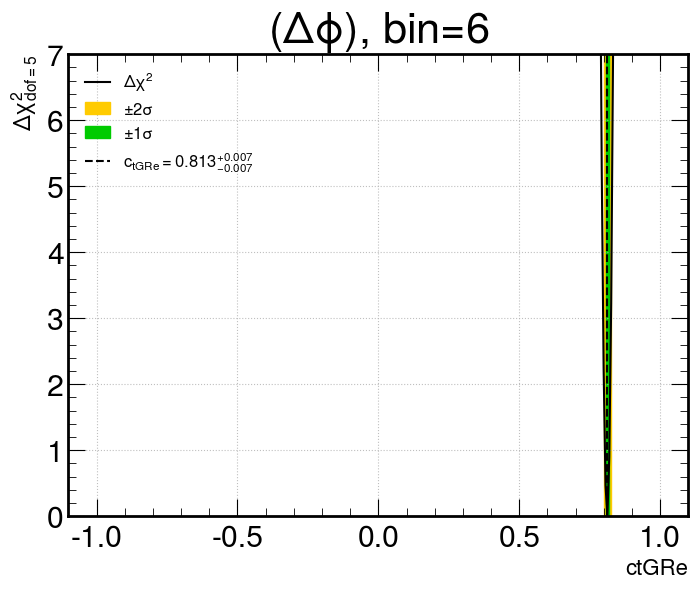

Plotting chi-square values for ctGIm...


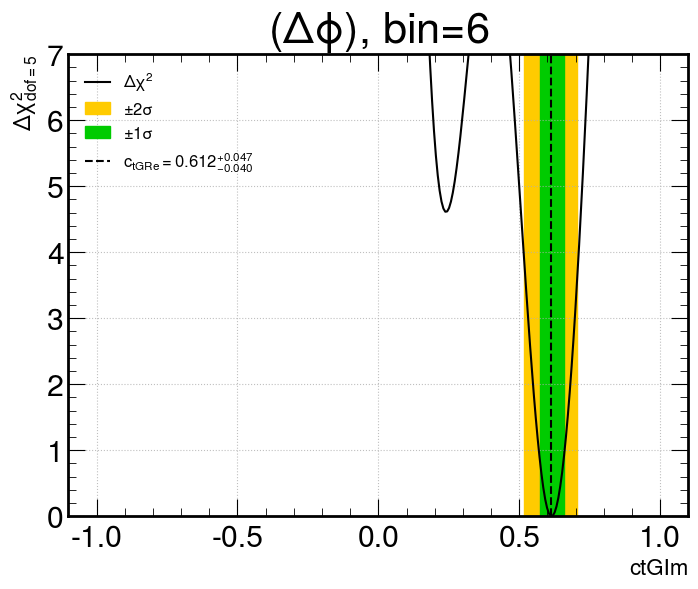

In [65]:
import Plot_limit_17

# Define the ylabel and observable variables
ylabel_chi = '$\Delta\chi^2_{dof=5}$'
variables = '$\Delta \phi$'  # You can add more variables like '$\Delta \phi_{ll}$' if needed

best_list={}
sig1_list={}
sig2_list={}
# Loop over chi-square statistics for each Wilson coefficient
for wc_name, chi_square_values in chi_squares.items():
    print(f"Plotting chi-square values for {wc_name}...")
    
    # Plot delta chi-square for this Wilson coefficient variation
    best, up1, down1,up2,down2 = Plot_limit_17.plot_delta_chi2(
        chi_square_values, wc_name, ylabel_chi, bins, variables
    )
    best_list[wc_name]=best
    sig1_list[wc_name]=(down1, up1)
    sig2_list[wc_name]=(down2,up2)


Plotting for ctGRe (wc_index: 0)


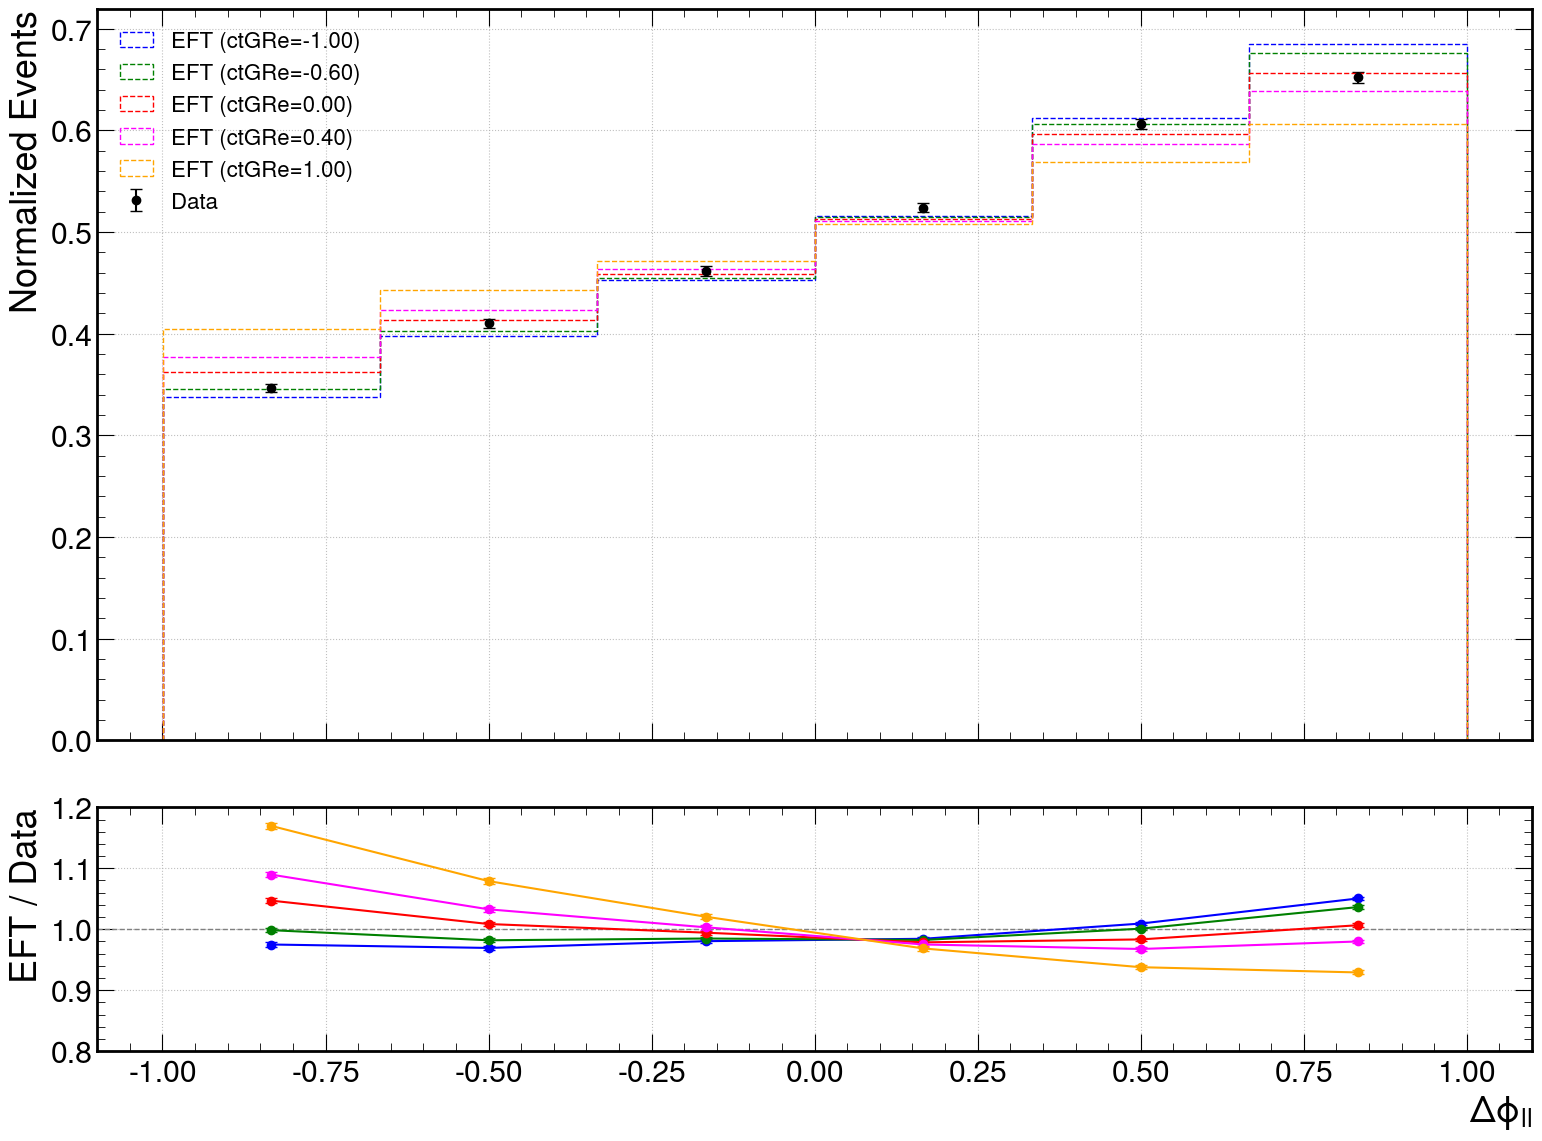

Plotting for ctGIm (wc_index: 1)


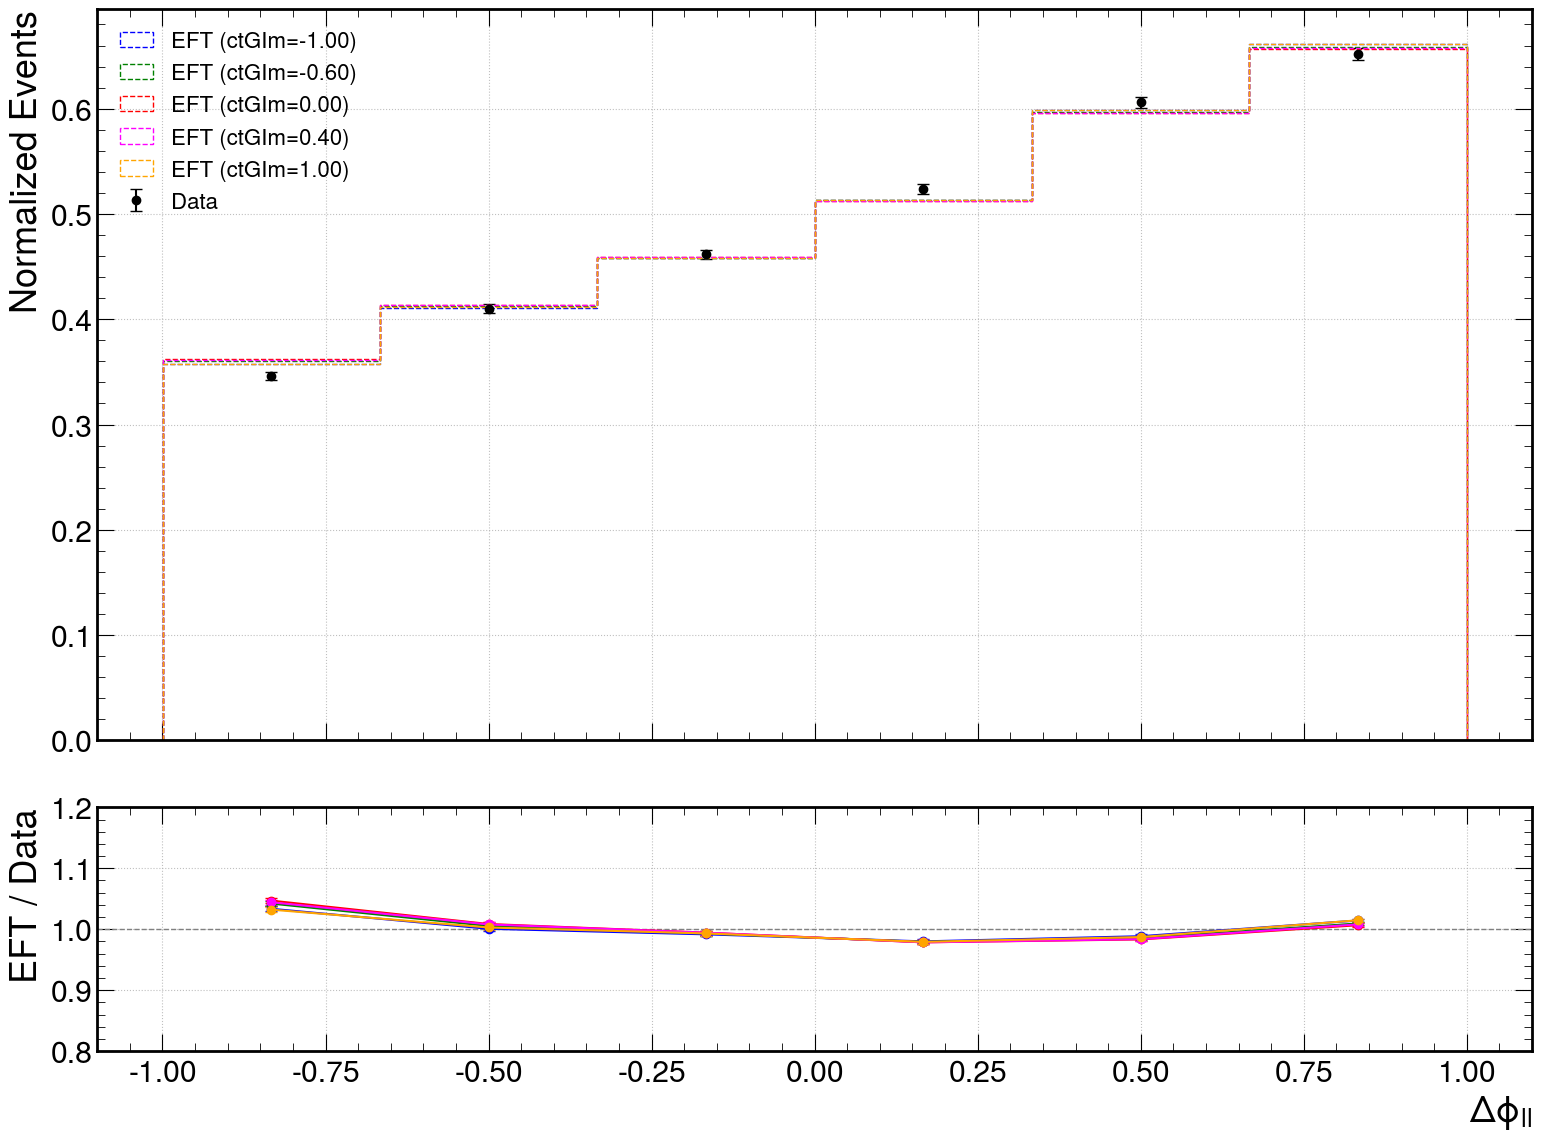

In [15]:
import Plot_SM_vs_EFT_29

# Dictionary to map wc_index to labels
wc_labels = {0: 'ctGRe', 1: 'ctGIm', 2: 'cQj18', 3: 'cQj38', 4: 'cQj11', 5: 'cQj31',
    6: 'ctu8', 7: 'ctd8', 8: 'ctj8', 9: 'cQu8', 10: 'cQd8', 11: 'ctu1', 
    12: 'ctd1', 13: 'ctj1', 14: 'cQu1', 15: 'cQd1'}


# Loop over computed histograms for each WC index
for wc_index, hist_data in histograms.items():
    wc_name = wc_labels.get(wc_index, f"wc_{wc_index}")  # Get name, default to wc_index if unknown
    print(f"Plotting for {wc_name} (wc_index: {wc_index})")  

    # Extract stored histograms for this WC index
    hist_obs_list = hist_data["hist_obs_list"]
    hist_obs_err_list = hist_data["hist_obs_err_list"]
    eft_events = hist_data["eft_events"]
    eft_errors = hist_data["eft_errors"]
    bin_edges = hist_data["bin_edges"]

    # Plot the histograms
    Plot_SM_vs_EFT_29.plot_sm_vs_eft_histograms(
        observables,
        bin_edges,
        hist_obs_list, 
        hist_obs_err_list, 
        eft_events, 
        eft_errors,
        x_label,
        wc_name=wc_name,
        legend_sizes=16
    )


In [16]:
import Reco_statistics_23

# Dictionary to map wc_index to labels
wc_labels = {0: 'ctGRe', 1: 'ctGIm', 2: 'cQj18', 3: 'cQj38', 4: 'cQj11', 5: 'cQj31',
    6: 'ctu8', 7: 'ctd8', 8: 'ctj8', 9: 'cQu8', 10: 'cQd8', 11: 'ctu1', 
    12: 'ctd1', 13: 'ctj1', 14: 'cQu1', 15: 'cQd1'}

# Dictionary to store chi-square statistics
chi_square_stat = {}

# Loop over computed histograms for each WC index
for wc_index, hist_data in histograms.items():
    # Get the WC name (e.g., "ctGRe" or "ctGIm")
    wc_name = wc_labels.get(wc_index, f"wc_{wc_index}")  # Default to wc_index if unknown  

    # Extract stored histograms for this WC index
    hist_obs_list = hist_data["hist_obs_list"]
    hist_obs_err_list = hist_data["hist_obs_err_list"]
    eft_events = hist_data["eft_events"]
    eft_errors = hist_data["eft_errors"]
    bin_edges = hist_data["bin_edges"]
    # Initialize a dictionary for storing chi-square values for this WC name
    chi_square_stat[wc_name] = {}
    
    # Loop through the eft_events for each variation (like ctGRe values)
    for ctgRe_value, hist_eft_list in eft_events.items():
        hist_eft_err_list = eft_errors[ctgRe_value]
        
        # Compute Chi-square for this EFT variation (ctGRe value)
        chi_square_value = Reco_statistics_23.compute_chi_square(
            hist_obs_list, hist_obs_err_list, hist_eft_list, hist_eft_err_list, bins
        )
        
        # Store the chi-square value for this variation
        chi_square_stat[wc_name][ctgRe_value] = chi_square_value  # No need for further averaging

    

In [17]:
chi_square_stat


{'ctGRe': {-1.0: 10.634090364347987,
  -0.8: 7.59321209708664,
  -0.6: 5.07710861280931,
  -0.3999999999999999: 3.453057702646494,
  -0.19999999999999996: 3.195451371531771,
  0.0: 4.8970566333510055,
  0.20000000000000018: 9.271820668713897,
  0.40000000000000013: 17.143247134396077,
  0.6000000000000001: 29.411337358124463,
  0.8: 46.991312289500556,
  1.0: 70.71982752864278},
 'ctGIm': {-1.0: 3.3403870135409774,
  -0.8: 3.7500646789314303,
  -0.6: 4.1796529338779544,
  -0.3999999999999999: 4.552112950876954,
  -0.19999999999999996: 4.8049150471533535,
  0.0: 4.8970566333510055,
  0.20000000000000018: 4.81383280557793,
  0.40000000000000013: 4.568555727524945,
  0.6000000000000001: 4.200927658628723,
  0.8: 3.7723533941070677,
  1.0: 3.358987950730981}}

Plotting chi-square values for ctGRe...


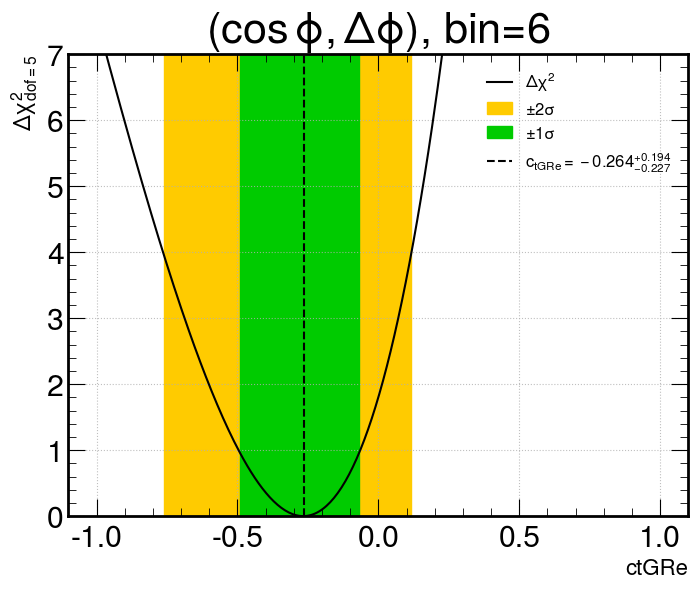

Plotting chi-square values for ctGIm...


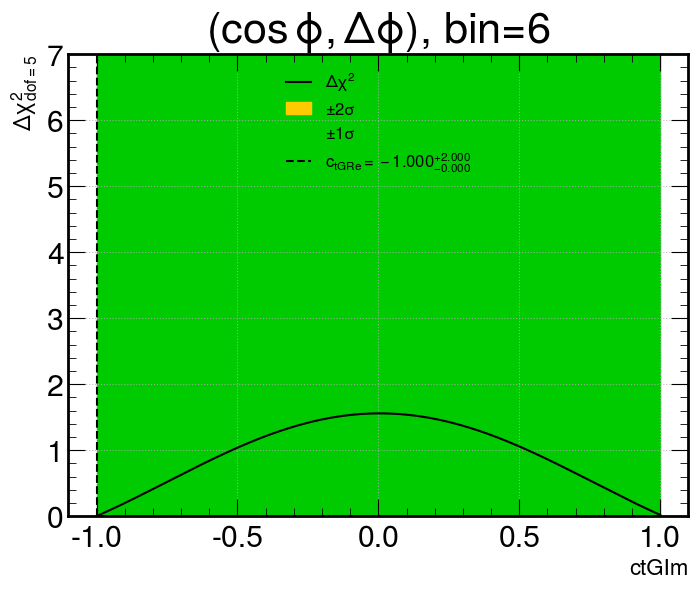

In [18]:
import Plot_limit_17

# Define the ylabel and observable variables
ylabel_chi = '$\Delta\chi^2_{dof=5}$'
variables = '$\cos \phi, \Delta \phi$'  # You can add more variables like '$\Delta \phi_{ll}$' if needed

best_list={}
sig1_list={}
sig2_list={}
# Loop over chi-square statistics for each Wilson coefficient
for wc_name, chi_square_values in chi_square_stat.items():
    print(f"Plotting chi-square values for {wc_name}...")
    
    # Plot delta chi-square for this Wilson coefficient variation
    best, up1, down1,up2,down2 = Plot_limit_17.plot_delta_chi2(
        chi_square_values, wc_name, ylabel_chi, bins, variables
    )
    best_list[wc_name]=best
    sig1_list[wc_name]=(down1, up1)
    sig2_list[wc_name]=(down2,up2)


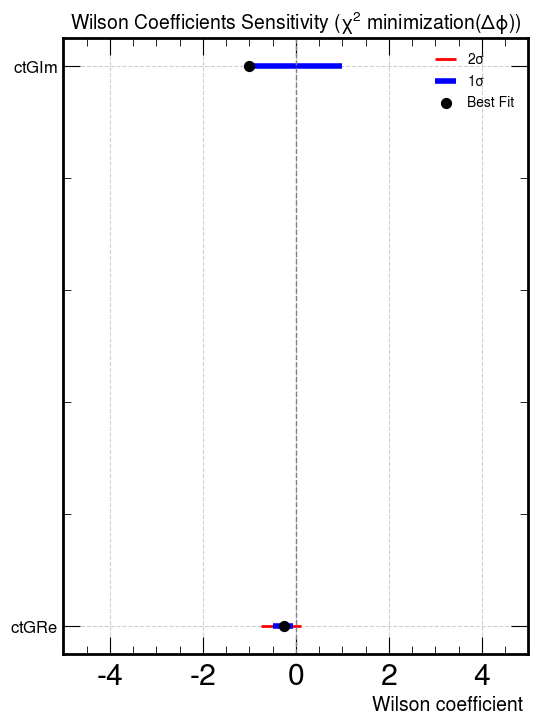

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting data
wilson_coeffs = list(best_list.keys())  # List of coefficient names
best_fit_values = [best_list[key] for key in wilson_coeffs]
sigma_1 = [sig1_list[key] for key in wilson_coeffs]  # Extract (lower, upper) 1σ
sigma_2 = [sig2_list[key] for key in wilson_coeffs]  # Extract (lower, upper) 2σ

# Convert to numpy arrays
y_positions = np.arange(len(wilson_coeffs))  # Vertical positioning

fig, ax = plt.subplots(figsize=(6, 8))

# Plot the 2σ confidence intervals in red
for i, (y, bf, (low2, high2)) in enumerate(zip(y_positions, best_fit_values, sigma_2)):
    ax.hlines(y, bf - low2, bf + high2, colors='red', lw=2, label=r"$2\sigma$" if i == 0 else "")

# Plot the 1σ confidence intervals in blue
for i, (y, bf, (low1, high1)) in enumerate(zip(y_positions, best_fit_values, sigma_1)):
    ax.hlines(y, bf - low1, bf + high1, colors='blue', lw=4, label=r"$1\sigma$" if i == 0 else "")

# Plot the best-fit points in black
ax.scatter(best_fit_values, y_positions, color='black', zorder=3, label="Best Fit", marker="o", s=50)

# Labels and formatting
ax.set_yticks(y_positions)
ax.set_yticklabels([f"${key}$" for key in wilson_coeffs], fontsize=12)
ax.set_xlabel(r"Wilson coefficient ", fontsize=14)
ax.axvline(0, color='gray', linestyle='dashed', lw=1)

ax.legend(loc="upper right", fontsize=10)
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_xlim(-5, 5)
plt.title(r"Wilson Coefficients Sensitivity ($\chi^2$ minimization($\Delta \phi$))", fontsize=14)

#plt.savefig("/depot/cms/top/bhanda25/EFT_minitree/Saved_plots/wilson_coefficients_sensitivity_delta_phi_4.png", dpi=300, bbox_inches='tight')
plt.show()


In [592]:
import Event_weight_prediction
import numpy as np
import Computed_statistics_chi_square4
import Reco_statistics_8
import test_statisticsPLR_7  # New module replacing Chi-square with Poisson PLR

# Path to structure constants
path_to_SC = '/depot/cms/top/bhanda25/EFT_minitree/Stored_SC/Stored_emu_Reco.npy'

# Event weights at reco
eft_reco_weights = file['eventWeight']

# Define Wilson coefficient indices to scan
wc_indices = [0, 1]  # Extend this list for other WCs if needed

# Define binning and list of observables
bins = 6
x_label = r"$cos \phi$"  # Example observable

# Loop over WC indices and compute histograms
histograms_1 = {}
#poisson_test_statistics = {}

for wc_index in wc_indices:
    # Compute event weights for the given wc_index
    event_weights, weight_sm = Computed_statistics_chi_square4.compute_event_weights_ctgRe(
        file, mask_file1, path_to_SC, wc_index=wc_index, ctgRe_min=-5, ctgRe_max=5, num_points=11
    )

    # Compute histograms for the given WC using Poisson-based PLR statistics
    hist_obs_list, eft_events, bin_edges = test_statisticsPLR_7.compute_values_for_poisson_PLR(
        data,
        eft,  # Pass list of observables
        event_weights,
        eft_reco_weights,
        bins
    )
     # Compute Poisson PLR for each EFT variation
    #plr_stat, best_fit_c = test_statisticsPLR_6.compute_poisson_PLR(
        #hist_obs_list, counts_obs_list, eft_events, bins
    #)

    # Store results for this WC
    histograms_1[wc_index] = {
        "hist_obs_list": hist_obs_list,
        "eft_events": eft_events,
        "bin_edges": bin_edges
    }
    
    #poisson_test_statistics[wc_index] = plr_stat

# Now `histograms` contains results for each wc_index
# `poisson_test_statistics` contains the PLR test statistics for each WC


In [593]:
histograms_1

{0: {'hist_obs_list': [array([0.34617905, 0.4101474 , 0.46160218, 0.5239894 , 0.60607309,
          0.65206164])],
  'eft_events': {-5.0: [array([0.31591029, 0.38618836, 0.44893993, 0.51841737, 0.62395046,
           0.70664633])],
   -4.0: [array([0.3164883 , 0.3859564 , 0.44862934, 0.51834746, 0.62391216,
           0.70671909])],
   -3.0: [array([0.31886973, 0.38681135, 0.44872483, 0.51805597, 0.6227757 ,
           0.70481518])],
   -2.0: [array([0.32478454, 0.38991866, 0.44970921, 0.51733008, 0.61942129,
           0.69888897])],
   -1.0: [array([0.33749791, 0.39755235, 0.45255023, 0.51576804, 0.61169521,
           0.68498901])],
   0.0: [array([0.36242724, 0.41365289, 0.45898073, 0.5127029 , 0.59593359,
           0.6563554 ])],
   1.0: [array([0.40488126, 0.44252894, 0.47103846, 0.50748026, 0.56830432,
           0.60581951])],
   2.0: [array([0.45858558, 0.48091249, 0.4877006 , 0.50087008, 0.53235049,
           0.5396335 ])],
   3.0: [array([0.49658552, 0.51030438, 0.50118596

In [664]:
import test_statisticsPLR_11  # Module that contains compute_poisson_PLR function

# Dictionary to map wc_index to labels
wc_labels = {
    0: 'ctGRe', 1: 'ctGIm', 2: 'cQj18', 3: 'cQj38', 4: 'cQj11', 5: 'cQj31',
    6: 'ctu8', 7: 'ctd8', 8: 'ctj8', 9: 'cQu8', 10: 'cQd8', 11: 'ctu1',
    12: 'ctd1', 13: 'ctj1', 14: 'cQu1', 15: 'cQd1'
}

# Dictionary to store Poisson PLR statistics
poisson_plr_stat = {}

# Loop over computed histograms for each WC index
for wc_index, hist_data in histograms_1.items():
    # Get the WC name (e.g., "ctGRe" or "ctGIm")
    wc_name = wc_labels.get(wc_index, f"wc_{wc_index}")  # Default to wc_index if unknown  

    # Extract stored histograms for this WC index
    hist_obs_list = hist_data["hist_obs_list"]
    eft_events = hist_data["eft_events"]
    bin_edges = hist_data["bin_edges"]

    # Initialize a dictionary for storing Poisson PLR values for this WC name
    poisson_plr_stat[wc_name] = {}

    # Compute Poisson PLR for each EFT variation
    plr_stat, best_fit_c = test_statisticsPLR_11.compute_poisson_PLR(
        hist_obs_list, eft_events, bins
    )

    # Store the Poisson PLR value for this Wilson coefficient
    poisson_plr_stat[wc_name]= plr_stat

# Now `poisson_plr_stat` contains the Poisson PLR test statistics for each WC


In [665]:
poisson_plr_stat

{'ctGRe': {-5.0: -0.004148857958114031,
  -4.0: -0.0041226748425937385,
  -3.0: -0.0036805741487516523,
  -2.0: -0.0025387027777410047,
  -1.0: -0.000678244746119694,
  0.0: 0.0,
  1.0: -0.008387437263611498,
  2.0: -0.03702592354721087,
  3.0: -0.07139046433035125,
  4.0: -0.07871924659320162,
  5.0: -0.06397384387145755},
 'ctGIm': {-5.0: -0.005502826990119485,
  -4.0: -0.0032661277238945656,
  -3.0: -0.0012773218983641375,
  -2.0: -0.00011222654450946659,
  -1.0: 0.0,
  0.0: -0.00019580091078661615,
  1.0: -2.9183087598084665e-06,
  2.0: -0.0001015442999211275,
  3.0: -0.0012414599057481092,
  4.0: -0.003206194981351363,
  5.0: -0.005426119472760883}}

In [581]:
'ctGRe': {-5.0: 0.0016595431832456126,
  -4.0: 0.0016490699370374953,
  -3.0: 0.001472229659500661,
  -2.0: 0.001015481111096402,
  -1.0: 0.0002712978984478776,
  0.0: -0.0,
  1.0: 0.0033549749054445992,
  2.0: 0.014810369418884348,
  3.0: 0.0285561857321405,
  4.0: 0.031487698637280646,
  5.0: 0.02558953754858302},
 'ctGIm': {-5.0: 0.002201130796047794,
  -4.0: 0.0013064510895578261,
  -3.0: 0.000510928759345655,
  -2.0: 4.4890617803786637e-05,
  -1.0: -0.0,
  0.0: 7.832036431464645e-05,
  1.0: 1.1673235039233867e-06,
  2.0: 4.0617719968451e-05,
  3.0: 0.0004965839622992436,
  4.0: 0.0012824779925405452,
  5.0: 0.002170447789104353}}


289682.63514248224